In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [2]:
import os

def show_env_var(varname):
    if varname in os.environ:
        print(f'{varname}: {os.environ[varname]}')
    else:
        print(f'{varname} undefined')

show_env_var('MODIN_OUT_OF_CORE')
show_env_var('MODIN_MEMORY')
show_env_var('MODIN_ON_RAY_PLASMA_DIR')

MODIN_OUT_OF_CORE: true
MODIN_MEMORY: 500000000
MODIN_ON_RAY_PLASMA_DIR: /home/adrian/tmp


In [3]:
import sys
sys.path.append('../src')

import ray
import modin

import numpy as np
import pandas as pd
import tensorflow as tf

from util import tf_detected_devices, tf_version, plot_model, Config, LoggerFactory, create_path

from tensorflow.keras.callbacks import ModelCheckpoint
from callback import MetricsPlotter
from data import InMemoryXyDataGenerator
from recommendation import UserMovieGenderEmbeddingDenseModelFactory, RecommendationsDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [4]:
modin.__version__

'0.8.3'

In [5]:
ray.shutdown()

In [6]:
if not ray.is_initialized():
    ray.init(num_cpus=24, num_gpus=1, dashboard_host="0.0.0.0", dashboard_port=8080)
else:
    print('Ray is already active!')

2021-02-12 22:09:53,647	INFO services.py:1171 -- View the Ray dashboard at http://192.168.0.250:8080


## Logger config

In [7]:
config = Config(path='../config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Config parameters

Setup test_mode variable to enable or disable model train before check their prediction precision:

In [8]:
train_model = True

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [9]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce RTX 3080, 10010 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [10]:
tf_version()

'Tensorflow version: 2.5.0-dev20210209'

**Step 3**: Let's check devices that tensorflow detect:

In [11]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,7G,"device: 0, name: GeForce RTX 3080, pci bus id:..."


In [12]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [13]:
tf.test.is_built_with_cuda()

True

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

In [15]:
TEMP_PATH = './temp'
TRAIN_PATH = f'{TEMP_PATH}/train'
VAL_PATH = f'{TEMP_PATH}/val'
TEST_PATH = f'{TEMP_PATH}/test'

In [16]:
import glob

def read_csv(path):
    all_files = glob.glob(path)
    li = [pd.read_csv(filename, index_col=None, header=0) for filename in all_files]
    return pd.concat(li, axis=0, ignore_index=True)

In [17]:
train_set = read_csv(f'{TRAIN_PATH}/*.csv')

In [18]:
val_set = read_csv(f'{VAL_PATH}/*.csv')

In [19]:
test_set = read_csv(f'{TEST_PATH}/*.csv')

In [20]:
print(f'Train set size: {"{:,}".format(train_set.shape[0])} samples.')
print(f'Validation set size: {"{:,}".format(val_set.shape[0])} samples.')
print(f'Test set size: {"{:,}".format(test_set.shape[0])} samples.')

Train set size: 90,701 samples.
Validation set size: 6,836 samples.
Test set size: 3,035 samples.


**Step 3:** Let's see min and max value of rating column.

In [21]:
min_rating, max_rating = train_set['rating'].min(), train_set['rating'].max()

print('Rattings:\n - min:', min_rating, '\n - max:', max_rating)

Rattings:
 - min: 0.5 
 - max: 5.0


Calculate train, val batch_size and plot interval.

In [387]:
import math

steps             = 4
epochs            = 35
plot_interval     = math.floor(steps / 2)

train_batch_size  = math.floor(train_set.shape[0] / steps)
val_batch_size    = math.floor(val_set.shape[0] / steps)
evaluate_interval = plot_interval + 1

In [388]:
print(f'Train Batch Size      : {"{:,}".format(train_batch_size)}.')
print(f'Validation Batch Size : {"{:,}".format(val_batch_size)}.')
print('Plot Interval         :', plot_interval)
print('Evaluate Interval     :', evaluate_interval)
print('Epochs                :', epochs)

Train Batch Size      : 22,675.
Validation Batch Size : 1,709.
Plot Interval         : 2
Evaluate Interval     : 3
Epochs                : 35


In [389]:
X_train = train_set[set(train_set.columns) - set(['user_id', 'movie_id', 'rating'])].values
y_train = train_set['rating'].values

In [390]:
X_val = val_set[set(val_set.columns) - set(['user_id', 'movie_id', 'rating'])].values
y_val = val_set['rating'].values

In [391]:
X_test = test_set[set(test_set.columns) - set(['user_id', 'movie_id', 'rating'])].values
y_test = test_set['rating'].values

In [392]:
def to_input(X, y): return [X[:, 0], X[:, 1], X[:, 2:22]], y

In [393]:
train_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    train_batch_size,
    shuffle=True, 
    to_input=to_input
)

In [394]:
batch = train_generator[0]
batch[0][0].shape, batch[0][1].shape, batch[0][2].shape

((22675,), (22675,), (22675, 20))

In [395]:
val_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val, 
    val_batch_size, 
    shuffle=True, 
    to_input=to_input
)

In [396]:
user_ids = set(np.concatenate((train_set['user_id'].values, val_set['user_id'].values, test_set['user_id'].values), axis=0))
n_users = len(user_ids)
n_users

610

In [397]:
movie_ids = set(np.concatenate((train_set['movie_id'].values, val_set['movie_id'].values, test_set['movie_id'].values), axis=0))
n_movies = len(movie_ids)
n_movies

9408

In [398]:
gender_columns = set(train_set.columns) - set(['user_id', 'movie_id', 'user_seq', 'movie_seq', 'rating'])

In [408]:
model = UserMovieGenderEmbeddingDenseModelFactory.create(
    n_users, 
    n_movies,
    n_genders=len(gender_columns),
    min_rating=min_rating, 
    max_rating=max_rating,
    user_n_min_factors=50,
    movie_n_min_factors=10,
    lr=0.001,
    units=[20],
    dropout=[0.1]
)

In [409]:
# plot_model(model, rankdir="TB")

In [410]:
# model.summary()

In [411]:
metrics = MetricsPlotter(
                validation_generator=val_generator, 
                metrics_names=['loss'],
                plot_interval=plot_interval,
                evaluate_interval=evaluate_interval,
                batch_size=train_batch_size,
                val_batch_size=val_batch_size
            )

checkpoints = ModelCheckpoint(
                filepath='./checkpoints/weights.epoch_{epoch:02d}-loss_{loss:.3f}-val_loss_{val_loss:.3f}.hdf5',
                save_weights_only=True,
                monitor='val_loss',
                mode='max',
                save_best_only=True
            )

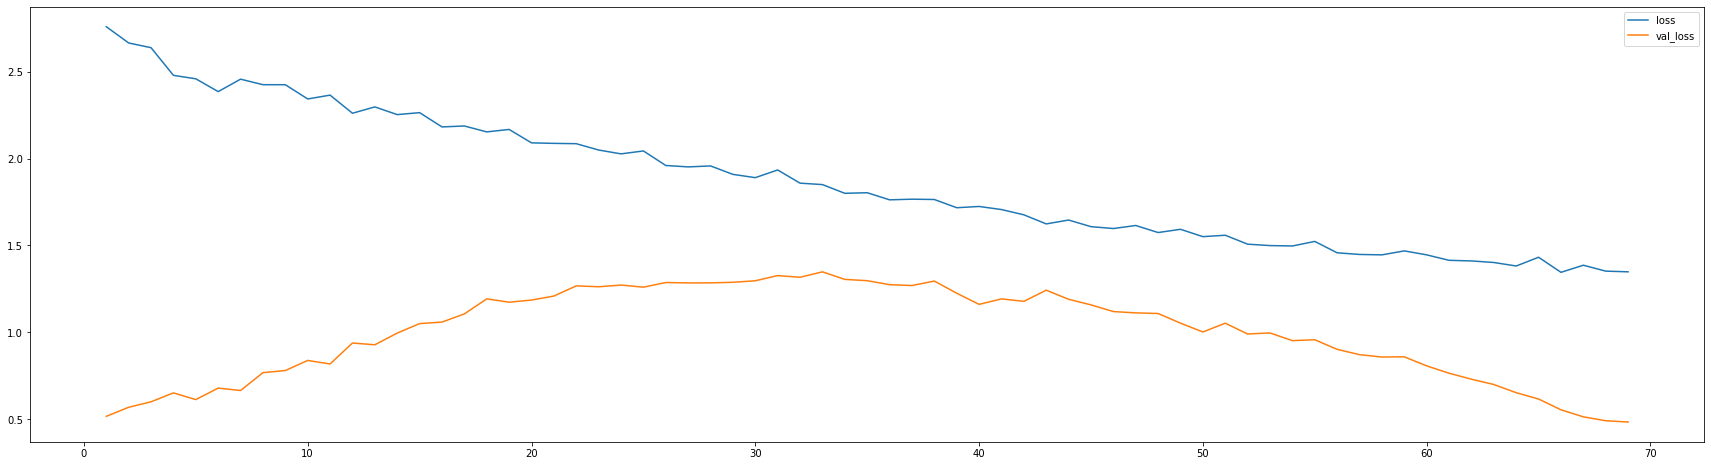

4/4 [==============================] - ETA: 0s - loss: 1.3380

Evaluate model each 3 steps(Batch-size: 1709):
1/1 [==============================] - 0s 10ms/step - loss: 0.4588

Val metrics:
  - Loss (70): 0.458824 (⟱ 0.02515447)

Continue model train:
4/4 [==============================] - 0s 95ms/step - loss: 1.3401 - val_loss: 0.4239


In [412]:
if train_model:
    history = model.fit_generator(
        generator=train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=1, 
        callbacks=[
            checkpoints,
            metrics
        ]
    )

In [417]:
def evaluate_model(model, samples, batch_size):
    X, y = samples[set(samples.columns) - set(['user_id', 'movie_id', 'rating'])].values, samples['rating'].values
    
    generator = InMemoryXyDataGenerator(
        X,
        y, 
        batch_size,
        shuffle=True, 
        to_input=to_input
    )
    X_batch, y_batch = generator[0]
    
    return model.evaluate(X_batch, y_batch, batch_size=batch_size, verbose=0)

In [418]:
evaluate_model(model, train_set, batch_size=train_batch_size)

0.2043474316596985

In [419]:
evaluate_model(model, val_set, batch_size=train_batch_size)

0.43783125281333923

In [420]:
evaluate_model(model, test_set, batch_size=train_batch_size)

0.6181782484054565